# Differential Expression and Pathway analysis
The goal of this notebook is to take the processed feature counts and experimental design tables and use GSEA, ROntoTools, and QuaternaryProd to generate and compare pathway analyses. This notebook runs code in R using the DESeq2 differential expression package.

1. input full featureCount tables into DESeq2
2. ROntoTools
3. GSEA
4. QuaternaryProd with STRING database

## Preparation
1. install R packages (see R install document)


## Instructions
Before running this notebook, format the feature count data with the featureCountprocessing-generic notebook. The notebooks are separated because the processing notebook runs Python code, not R. Once the processed featureCounts and experimental design table have been created:

1. Run the first cell to import the necessary libraries and define the functions used to process the data.
2. 

In [17]:
#import libraries
library("DESeq2")

#define functions for DESeq2 object creation and heatmap creation
#based on Griffith Lab tutorial here: https://genviz.org/module-04-expression/0004/02/01/DifferentialExpression/

#input and process sample data (experiment design)
input_sample_data <- function(filepath, print_debug=FALSE){
    sampleData <- read.delim(filepath)
    #save copy of sampleData
    #sampleData_v2 <- sampleData
    
    rownames(sampleData) <- sampleData$SampleID.Lab
    #make data type = factor for Cell Line and Time Point (both otherwise treated as continuous variables since both are numbers)
    sampleData$Cell.Line <- factor(sampleData$Cell.Line)
    sampleData$Time.Point <- factor(sampleData$Time.Point)
    if(print_debug == TRUE){
        print(head(sampleData))
        }
    return(sampleData)
}

#Input and process raw gene counts (Feature Counts)
input_raw_counts <- function(filepath, sampleData, print_debug=FALSE){
    rawCounts <- read.delim(filepath)
    #print(head(rawCounts))
    
    geneID <- rawCounts$Geneid
    sampleIndex <- grepl("ES\\d+", colnames(rawCounts))
    rawCounts <- as.matrix(rawCounts[,sampleIndex])
    rownames(rawCounts) <- geneID
     if(print_debug == TRUE){
        print(head(rawCounts))
    }
    rawCounts <- rawCounts[,unique(rownames(sampleData))]
    if(print_debug == TRUE){
        print(head(rawCounts))
    }
    cat("Test that dimensions of rawCounts and sampleData match:", all(colnames(rawCounts) == rownames(sampleData)), "\n")
    return(rawCounts)
}


## Comparisons to make:
1. MRTX alone vs. MRTX + BI and vs MRTX + SHP2i at 6 and 72 hr (H358 only for SHP2i)
2. 0 vs. 6, 0 vs. 72 hr, and 6 hr vs. 72 hr within drug treatments
4. MRTX + BI vs MRTX + SHP2i at 6 and 72 hr (H358 only)
5. S2 KO vs S2 KO + MRTX
6. NT + MRTX + BI vs S2 KO + MRTX + BI

In [21]:
#H358 input rawCounts (featureCounts) and sample data (experimental design)
sampleData_H358 <- input_sample_data("20210209_experiment_design_H358.tsv")
rawCounts_H358 <- input_raw_counts("20210209_featureCount_H358.tsv", sampleData_H358)
#make DESeq2DataSet object, specifying CRISPR status as a blocking factor and Time point as the comparison variable
#choosing blocking factor and comparison variable is required, and if there are no divisions in the category chosen an error will occur "model matrix is not full rank"
dds_H358 <- DESeqDataSetFromMatrix(countData=rawCounts_H358, colData=sampleData_H358, design= ~ CRISPR + Time.Point)

Test that dimensions of rawCounts and sampleData match: TRUE 


In [60]:
sampleData_H358_72_MB <- input_sample_data("20210209_experiment_design_H358_72_MB.tsv")
rawCounts_H358_72_MB <- input_raw_counts("20210209_featureCount_H358.tsv", sampleData_H358_72_MB)
#make DESeq2DataSet object, specifying CRISPR status as a blocking factor and Time point as the comparison variable
#choosing blocking factor and comparison variable is required, and if there are no divisions in the category chosen an error will occur "model matrix is not full rank"
dds_H358_72_MB <- DESeqDataSetFromMatrix(countData=rawCounts_H358_72_MB, colData=sampleData_H358_72_MB, design= ~ Population + BI)

Test that dimensions of rawCounts and sampleData match: TRUE 


In [24]:
#View sampleData to understand its format/information when choosing variables later
head(sampleData_H358)

,X,SampleID.Lab,Cell.Line,Inhibition.Status,CRISPR,MRTX,BI,SHP2i,Time.Point,Population
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
ES58NTXX01,0,ES58NTXX01,58,NTXX,NT,False,False,False,0,A
ES58NTXX02,1,ES58NTXX02,58,NTXX,NT,False,False,False,0,A
ES58NTXX03,2,ES58NTXX03,58,NTXX,NT,False,False,False,0,B
ES58NTXX04,3,ES58NTXX04,58,NTXX,NT,False,False,False,0,B
ES58S1XX01,4,ES58S1XX01,58,S1XX,S1,False,False,False,0,A
ES58S1XX02,5,ES58S1XX02,58,S1XX,S1,False,False,False,0,A


In [20]:
#filter for genes with at least 5 counts across all samples to reduce dimensions
##Make function
print(dim(dds_H358))
print(dim(dds_H358[rowSums(counts(dds_H358)) > 5, ]))
dds_H358 <- dds_H358[rowSums(counts(dds_H358)) > 5, ]

[1] 63677    59

[1] 34696    59

In [61]:
#filter for genes with at least 5 counts across all samples to reduce dimensions
print(dim(dds_H358_72_MB))
print(dim(dds_H358_72_MB[rowSums(counts(dds_H358_72_MB)) > 5, ]))
dds_H358_72_MB <- dds_H358_72_MB[rowSums(counts(dds_H358_72_MB)) > 5, ]

[1] 63677     8
[1] 27119     8


In [22]:
#load BiocParallel library and register number of cores to use (based on CPU) for parallel processing to increase speed
#if used set parallel = TRUE for DEseq() and results()
library(BiocParallel)
register(MulticoreParam(4))

In [52]:
#perform DESeq on dataset object to estimate size factors, dispersion, and find negative bionomial GLM fitting and Wald statistic
#Takes 5-10 minutes without parallel processing, 1-5 minutes with 4 cores
dds_H358_DESeq <- DESeq(dds_H358, parallel=TRUE)

estimating size factors

estimating dispersions

gene-wise dispersion estimates: 4 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 4 workers

-- replacing outliers and refitting for 4 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [57]:
dds_H358_results <- results(dds_H358_DESeq, contrast=c("Time.Point", "0", "72"))
summary(dds_H358_results)


out of 42301 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 6522, 15%
LFC < 0 (down)     : 7624, 18%
outliers [1]       : 2, 0.0047%
low counts [2]     : 15167, 36%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



## Quality control plots for whole dataset

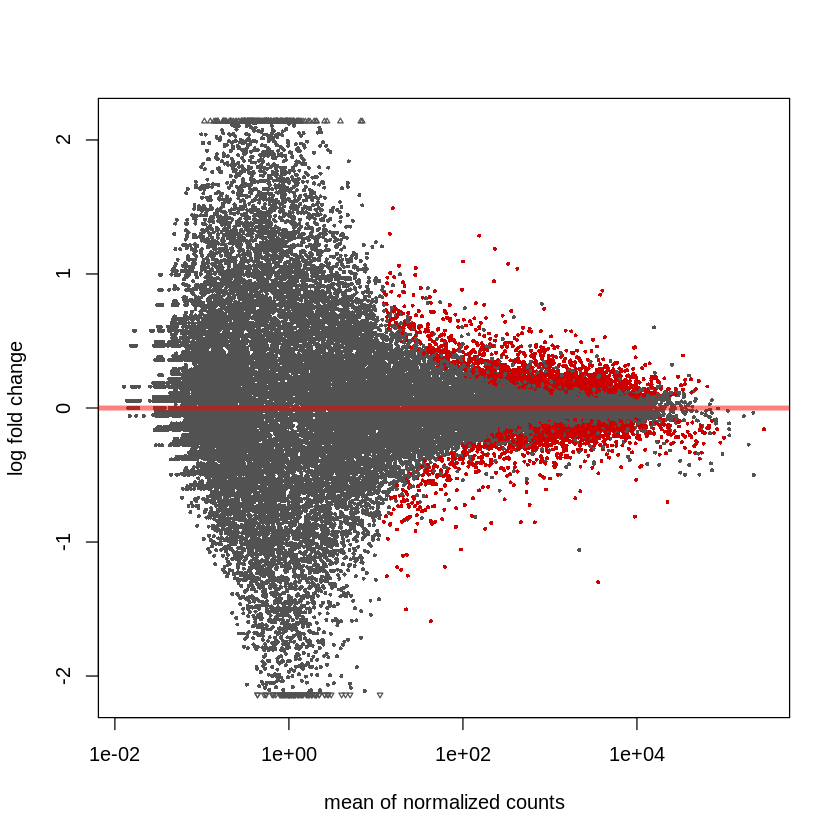

In [27]:
plotMA(dds_H358_results)


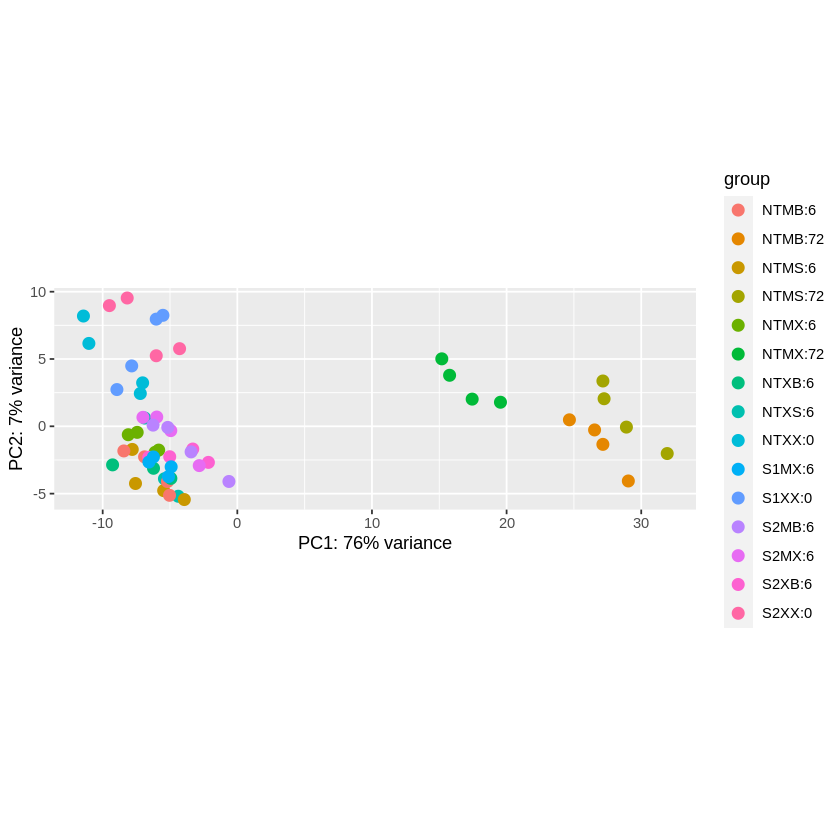

In [30]:
#PCA and sample distances
vsd <- vst(dds_H358_DESeq, blind=FALSE)
plotPCA(vsd, intgroup=c("Inhibition.Status", "Time.Point"))

In [34]:
plt <- plotPCA(vsd, intgroup=c("CRISPR", "Population"))

In [38]:
#print to file
png("Results/H358_PCA_cell_pop.png")
print(plt)
dev.off()

png 
  2

In [39]:
plt <- plotPCA(vsd, intgroup=c("Inhibition.Status", "Time.Point"))
png("Results/H358_PCA_inhib-timept.png")
print(plt)
dev.off()

png 
  2

In [ ]:
#save dds object as .RData
#from https://bioinformatics-core-shared-training.github.io/cruk-summer-school-2020/RNAseq/html/04_DE_analysis_with_DESeq2.html#finally-save-the-results-in-a-new-rdata-object
#Extract the default contrast - Lacate v Virgin
#resLvV <- results(ddsObj, alpha=0.05)
#save(resLvV, ddsObj, sampleinfo, file="results/DE.RData")


## Set up dataset subsets for comparisons

In [62]:
#only 72 hour MRTX vs MRTX + BI comparison
dds_H358_72_MB <- DESeq(dds_H358_72_MB, parallel=TRUE)

estimating size factors

estimating dispersions

gene-wise dispersion estimates: 4 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 4 workers



In [67]:
dds_H358_72_MB$Inhibition.Status <- relevel(dds_H358_72_MB$Inhibition.Status, ref = "NTMX")
dds_H358_72_MB$Inhibition.Status

[1] NTMX NTMX NTMX NTMX NTMB NTMB NTMB NTMB
Levels: NTMX NTMB

In [74]:
dds_H358_72_MB_results <- results(dds_H358_72_MB, name="BI_True_vs_False")
summary(dds_H358_72_MB_results)


out of 27119 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1578, 5.8%
LFC < 0 (down)     : 1181, 4.4%
outliers [1]       : 0, 0%
low counts [2]     : 10516, 39%
(mean count < 14)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



# Implement Pathway Analysis: ROntoTools with KEGG HSA (human KEGG pathways)

From https://www.bioconductor.org/packages/release/bioc/vignettes/ROntoTools/inst/doc/rontotools.pdf

In [ ]:
library(ROntoTools)

### Load, examine, and process human KEGG pathways

In [82]:
#Download and parse KEGG pathways
require(graph)
require(ROntoTools)
kpg <- keggPathwayGraphs("hsa", verbose = FALSE)

Loading required package: graph

Loading required package: ROntoTools

Loading required package: boot

Loading required package: KEGGREST

Loading required package: KEGGgraph


Attaching package: ‘KEGGgraph’


The following object is masked from ‘package:graphics’:

    plot


Loading required package: Rgraphviz

Loading required package: grid


Attaching package: ‘Rgraphviz’


The following objects are masked from ‘package:IRanges’:

    from, to


The following objects are masked from ‘package:S4Vectors’:

    from, to


Using cached pathway data. Database info:
pathway          KEGG Pathway Database
path             Release 73.0+/01-03, Jan 15
                 Kanehisa Laboratories
                 343,170 entries

Default parameters detected. Using pre-parsed data.



In [ ]:
#update cache and download latest KEGG pathways
#kpg <- keggPathwayGraphs("hsa", updateCache = TRUE, verbose = TRUE)

In [85]:
#Options to inspect the pathways, see ROntoTools vignette on Bioconductor for more
#head(names(kpg))
#kpg[["path:hsa04110"]]
#head(nodes(kpg[["path:hsa04110"]]))

#the parser extracted the type of interaction for each gene-gene interaction in anattribute called subtype
#head(edgeData(kpg[["path:hsa04110"]], attr = "subtype"))

$`hsa:1029|hsa:4193`
[1] "inhibition"

$`hsa:1029|hsa:1019`
[1] "inhibition"

$`hsa:1029|hsa:1021`
[1] "inhibition"

$`hsa:1029|hsa:595`
[1] "inhibition"

$`hsa:1029|hsa:894`
[1] "inhibition"

$`hsa:1029|hsa:896`
[1] "inhibition"

In [87]:
#Using this attribute the function setEdgeWeights sets the same weight for all the interactions of the same type
kpg <- setEdgeWeights(kpg, edgeTypeAttr = "subtype", 
                      edgeWeightByType = list(activation = 1, inhibition = -1, 
                                              expression = 1, repression = -1),
                      defaultWeight = 0)

In [88]:
#retrieve the title of the pathways and not just their ids with the function keggPathwayNames
kpn <- keggPathwayNames("hsa")
head(kpn)

Using cached pathway data. Database info:
pathway          KEGG Pathway Database
path             Release 73.0+/01-03, Jan 15
                 Kanehisa Laboratories
                 343,170 entries



path:hsa03008                       path:hsa03013 
"Ribosome biogenesis in eukaryotes"                     "RNA transport" 
                      path:hsa03015                       path:hsa03018 
        "mRNA surveillance pathway"                   "RNA degradation" 
                      path:hsa03320                       path:hsa03460 
           "PPAR signaling pathway"            "Fanconi anemia pathway"

In [81]:
##Needs logFC, p value, adjusted pvalue, and gene pathway assignment, ordered by p value, from DESeq2 results table
#print(dds_H358_72_MB_results)
top_H358_72_MB <- dds_H358_72_MB_results[c("log2FoldChange","pvalue","padj")]
#order by pvalue (ascending)
top_H358_72_MB <- top_H358_72_MB[order(top_H358_72_MB$pvalue),]
top_H358_72_MB
#names(my_data)[names(my_data) == "Sepal.Length"] <- "sepal_length"

log2 fold change (MLE): BI True vs False 
Wald test p-value: BI True vs False 
DataFrame with 27119 rows and 3 columns
                       log2FoldChange               pvalue                 padj
                            <numeric>            <numeric>            <numeric>
ENSG00000138061     0.868073081937396 1.54695480209011e-71 2.56840905791022e-67
ENSG00000211459      2.50525467019162 9.63630160827448e-60 7.99957578010906e-56
ENSG00000137673      1.57739186727768 2.25031315512132e-54 1.24539831048264e-50
ENSG00000131747     -1.13200133156386 4.54098106782179e-52 1.88484771672613e-48
ENSG00000184254     0.833851390434383 2.12858319916875e-50 7.06817337115976e-47
...                               ...                  ...                  ...
ENSG00000248483 -0.000292476933361094    0.999821302232857                   NA
ENSG00000164619  0.000106630425746208    0.999835282849552    0.999895506634809
ENSG00000269110  0.000274976495039562    0.999870366461465                   NA
E

In [145]:
#library("clipr")
#write_clip(rownames(top_H358_72_MB), allow_non_interactive = TRUE)
#rownames(top_H358_72_MB)
#####write to a text file with comma separation, paste into DAVID gene converter to get entrez IDs, paste into KEGG converter to get KEGG IDs?
#Use AnnotationDbi, code from https://www.biostars.org/p/441386/
library("AnnotationDbi")
library("org.Hs.eg.db")
#columns(org.Hs.eg.db) # returns list of available keytypes
top_H358_72_MB$entrez = mapIds(org.Hs.eg.db,
                    keys=row.names(top_H358_72_MB), #Column containing Ensembl gene ids
                    column="ENTREZID",
                    keytype="ENSEMBL",
                    multiVals="first")
top_H358_72_MB

[1] "ENSG00000138061" "ENSG00000211459" "ENSG00000137673" "ENSG00000131747"
    [5] "ENSG00000184254" "ENSG00000100292" "ENSG00000041982" "ENSG00000204544"
    [9] "ENSG00000183856" "ENSG00000184564" "ENSG00000139318" "ENSG00000060982"
   [13] "ENSG00000148773" "ENSG00000171848" "ENSG00000105877" "ENSG00000166920"
   [17] "ENSG00000141574" "ENSG00000244405" "ENSG00000210082" "ENSG00000117724"
   [21] "ENSG00000151726" "ENSG00000189057" "ENSG00000140465" "ENSG00000202198"
   [25] "ENSG00000181019" "ENSG00000011426" "ENSG00000124145" "ENSG00000158055"
   [29] "ENSG00000127954" "ENSG00000156802" "ENSG00000113282" "ENSG00000137501"
   [33] "ENSG00000165959" "ENSG00000160211" "ENSG00000152256" "ENSG00000169550"
   [37] "ENSG00000185275" "ENSG00000135842" "ENSG00000198901" "ENSG00000166689"
   [41] "ENSG00000004799" "ENSG00000175832" "ENSG00000237807" "ENSG00000104081"
   [45] "ENSG00000140525" "ENSG00000168453" "ENSG00000073282" "ENSG00000137804"
   [49] "ENSG00000145147" "ENSG00000101057" "ENSG00000163993" "ENSG00000112782"
   [53] "ENSG00000066279" "ENSG00000163083" "ENSG00000166068" "ENSG00000113368"
   [57] "ENSG00000147027" "ENSG00000125398" "ENSG00000200434" "ENSG00000137801"
   [61] "ENSG00000144366" "ENSG00000010278" "ENSG00000125347" "ENSG00000176597"
   [65] "ENSG00000156970" "ENSG00000137745" "ENSG00000163683" "ENSG00000115339"
   [69] "ENSG00000067225" "ENSG00000134258" "ENSG00000063438" "ENSG00000184012"
   [73] "ENSG00000147883" "ENSG00000087510" "ENSG00000163046" "ENSG00000135373"
   [77] "ENSG00000102144" "ENSG00000152952" "ENSG00000121064" "ENSG00000162433"
   [81] "ENSG00000175274" "ENSG00000006468" "ENSG00000024526" "ENSG00000185633"
   [85] "ENSG00000068489" "ENSG00000160190" "ENSG00000176945" "ENSG00000134986"
   [89] "ENSG00000186417" "ENSG00000196167" "ENSG00000085831" "ENSG00000144354"
   [93] "ENSG00000231925" "ENSG00000120875" "ENSG00000167755" "ENSG00000135476"
   [97] "ENSG00000117226" "ENSG00000133985" "ENSG00000167600" "ENSG00000138670"
  [101] "ENSG00000102886" "ENSG00000187678" "ENSG00000242265" "ENSG00000076382"
  [105] "ENSG00000089685" "ENSG00000142945" "ENSG00000196517" "ENSG00000182158"
  [109] "ENSG00000145431" "ENSG00000167900" "ENSG00000196141" "ENSG00000048052"
  [113] "ENSG00000082684" "ENSG00000184292" "ENSG00000197822" "ENSG00000070731"
  [117] "ENSG00000171621" "ENSG00000113645" "ENSG00000177570" "ENSG00000174130"
  [121] "ENSG00000120885" "ENSG00000196730" "ENSG00000185215" "ENSG00000174125"
  [125] "ENSG00000134152" "ENSG00000079156" "ENSG00000069122" "ENSG00000114480"
  [129] "ENSG00000251705" "ENSG00000074527" "ENSG00000141736" "ENSG00000210140"
  [133] "ENSG00000013588" "ENSG00000181577" "ENSG00000088325" "ENSG00000256229"
  [137] "ENSG00000163513" "ENSG00000169679" "ENSG00000221963" "ENSG00000091409"
  [141] "ENSG00000144369" "ENSG00000124762" "ENSG00000196083" "ENSG00000105339"
  [145] "ENSG00000118515" "ENSG00000163131" "ENSG00000185909" "ENSG00000073060"
  [149] "ENSG00000237649" "ENSG00000163141" "ENSG00000196754" "ENSG00000144810"
  [153] "ENSG00000131981" "ENSG00000101447" "ENSG00000163191" "ENSG00000169439"
  [157] "ENSG00000109805" "ENSG00000213462" "ENSG00000104687" "ENSG00000180198"
  [161] "ENSG00000123095" "ENSG00000076003" "ENSG00000162949" "ENSG00000178999"
  [165] "ENSG00000269858" "ENSG00000146411" "ENSG00000170312" "ENSG00000109107"
  [169] "ENSG00000065833" "ENSG00000186185" "ENSG00000138413" "ENSG00000146670"
  [173] "ENSG00000121152" "ENSG00000121895" "ENSG00000121039" "ENSG00000188112"
  [177] "ENSG00000198826" "ENSG00000162804" "ENSG00000012048" "ENSG00000163435"
  [181] "ENSG00000112984" "ENSG00000183722" "ENSG00000145386" "ENSG00000105388"
  [185] "ENSG00000174444" "ENSG00000118640" "ENSG00000108100" "ENSG00000187689"
  [189] "ENSG00000196159" "ENSG00000166508" "ENSG00000065882" "ENSG00000110375"
  [193] "ENSG00000168496" "ENSG00000186350" "ENSG00000205220" "ENSG00000076641"
  [197] "ENSG00000102359" "ENSG00000112419" "ENSG00000172927" "ENSG00000152939"
  [2



'select()' returned 1:many mapping between keys and columns



log2 fold change (MLE): BI True vs False 
Wald test p-value: BI True vs False 
DataFrame with 27119 rows and 4 columns
                       log2FoldChange               pvalue                 padj
                            <numeric>            <numeric>            <numeric>
ENSG00000138061     0.868073081937396 1.54695480209011e-71 2.56840905791022e-67
ENSG00000211459      2.50525467019162 9.63630160827448e-60 7.99957578010906e-56
ENSG00000137673      1.57739186727768 2.25031315512132e-54 1.24539831048264e-50
ENSG00000131747     -1.13200133156386 4.54098106782179e-52 1.88484771672613e-48
ENSG00000184254     0.833851390434383 2.12858319916875e-50 7.06817337115976e-47
...                               ...                  ...                  ...
ENSG00000248483 -0.000292476933361094    0.999821302232857                   NA
ENSG00000164619  0.000106630425746208    0.999835282849552    0.999895506634809
ENSG00000269110  0.000274976495039562    0.999870366461465                   NA
E

In [136]:
#To get the pathway assignment, need the entrez ID for the gene
library(biomaRt)
# Retrieve the ensembl info
#ensembl <- useDataset("hsapiens_gene_ensembl", mart = ensembl)
ensembl <- useMart("ENSEMBL_MART_ENSEMBL", dataset = "hsapiens_gene_ensembl")
#
# Filter the ensembl ID
ids <- getBMlist(attributes=c("kegg_enzyme", "clone_based_ensembl_gene", "entrezgene_id"), filters="clone_based_ensembl_gene", values = "ENSG00000138061", mart = ensembl)
ids
#ids <- getBM(filters = "ensembl_gene_id", attributes = c("ensembl_gene_id", 'entrezgene_id', 'entrezgene_accession'), values = rownames(top_H358_72_MB), mart = ensembl)

Performing your query using getBM is preferred as getBMlist perfoms a separate getBM query for each of the values one gives.  This is ok for a short list but will definitely fail when used with longer lists.  Ideally one does a batch query with getBM and then iterates over that result.


ERROR: Error in UseMethod("filter_"): no applicable method for 'filter_' applied to an object of class "c('tbl_SQLiteConnection', 'tbl_dbi', 'tbl_sql', 'tbl_lazy', 'tbl')"


In [133]:
?getBM()

getBM {biomaRt},R Documentation
attributes,Attributes you want to retrieve. A possible list of attributes can be retrieved using the function listAttributes.
filters,Filters (one or more) that should be used in the query. A possible list of filters can be retrieved using the function listFilters.
values,"Values of the filter, e.g. vector of affy IDs. If multiple filters are specified then the argument should be a list of vectors of which the position of each vector corresponds to the position of the filters in the filters argument."
mart,"object of class Mart, created with the useMart function."
curl,"An optional 'CURLHandle' object, that can be used to speed up getBM when used in a loop."
checkFilters,"Sometimes attributes where a value needs to be specified, for example upstream\_flank with value 20 for obtaining upstream sequence flank regions of length 20bp, are treated as filters in BioMarts. To enable such a query to work, one must specify the attribute as a filter and set checkFilters = FALSE for the query to work."
verbose,"When using biomaRt in webservice mode and setting verbose to TRUE, the XML query to the webservice will be printed."
uniqueRows,"If the result of a query contains multiple identical rows, setting this argument to TRUE (default) will result in deleting the duplicated rows in the query result at the server side."
bmHeader,"Boolean to indicate if the result retrieved from the BioMart server should include the data headers or not, defaults to FALSE. This should only be switched on if the default behavior results in errors, setting to on might still be able to retrieve your data in that case"
quote,"Sometimes parsing of the results fails due to errors in the Ensembl data fields such as containing a quote, in such cases you can try to change the value of quote to try to still parse the results."


In [118]:
filters <- listFilters(ensembl)
attrib <- listAttributes(ensembl)
print(attrib[grep("Ensembl", attrib$description), ])
print(filters[grep("Ensembl", filters$description), ])

                             name                          description
53       clone_based_ensembl_gene        Clone-based (Ensembl) gene ID
54 clone_based_ensembl_transcript  Clone-based (Ensembl) transcript ID
59              ens_hs_transcript          Ensembl Human Transcript ID
60             ens_hs_translation         Ensembl Human Translation ID
71                   ens_lrg_gene       LRG display in Ensembl gene ID
72             ens_lrg_transcript LRG display in Ensembl transcript ID
           page
53 feature_page
54 feature_page
59 feature_page
60 feature_page
71 feature_page
72 feature_page
                                  name
14       with_clone_based_ensembl_gene
15 with_clone_based_ensembl_transcript
18              with_ens_hs_transcript
19             with_ens_hs_translation
30                   with_ens_lrg_gene
31             with_ens_lrg_transcript
72            clone_based_ensembl_gene
73      clone_based_ensembl_transcript
78                   ens_hs_transcript
7

In [92]:
listMarts()

biomart,version
<chr>,<chr>
ENSEMBL_MART_ENSEMBL,Ensembl Genes 103
ENSEMBL_MART_MOUSE,Mouse strains 103
ENSEMBL_MART_SNP,Ensembl Variation 103
ENSEMBL_MART_FUNCGEN,Ensembl Regulation 103


In [43]:
dds_H358_DESeq$SampleID.Lab

[1] ES58NTXX01 ES58NTXX02 ES58NTXX03 ES58NTXX04 ES58S1XX01 ES58S1XX02
 [7] ES58S1XX03 ES58S1XX04 ES58S2XX01 ES58S2XX02 ES58S2XX03 ES58S2XX04
[13] ES58NTMX01 ES58NTMX02 ES58NTMX03 ES58NTMX04 ES58NTMX05 ES58NTMX06
[19] ES58NTMX07 ES58NTMX08 ES58NTXS01 ES58NTXS02 ES58NTXS04 ES58NTMS01
[25] ES58NTMS02 ES58NTMS03 ES58NTMS04 ES58NTMS05 ES58NTMS06 ES58NTMS07
[31] ES58NTMS08 ES58NTMB01 ES58NTMB02 ES58NTMB03 ES58NTMB04 ES58NTMB05
[37] ES58NTMB06 ES58NTMB07 ES58NTMB08 ES58NTXB01 ES58NTXB02 ES58NTXB03
[43] ES58NTXB04 ES58S2XB01 ES58S2XB02 ES58S2XB03 ES58S2XB04 ES58S1MX01
[49] ES58S1MX02 ES58S1MX03 ES58S1MX04 ES58S2MX01 ES58S2MX02 ES58S2MX03
[55] ES58S2MX04 ES58S2MB01 ES58S2MB02 ES58S2MB03 ES58S2MB04
59 Levels: ES58NTMB01 ES58NTMB02 ES58NTMB03 ES58NTMB04 ... ES58S2XX04

## QuaternaryProd with STRING database
From https://bioconductor.org/packages/release/bioc/vignettes/QuaternaryProd/inst/doc/QuaternaryProdVignette.pdf

Data set needs:
1. entrez ID of gene
2. pvalue of gene
3. fold change of gene

## GSEA with GAGE/Pathview and KEGG pathways
From http://bioconductor.org/packages/release/bioc/vignettes/gage/inst/doc/RNA-seqWorkflow.pdf

In [143]:
library(gage)
ref.idx=5:8
samp.idx=1:4
data(kegg.gs)

In [144]:
kegg.gs

$`hsa00010 Glycolysis / Gluconeogenesis`
 [1] "10327"  "124"    "125"    "126"    "127"    "128"    "130"    "130589"
 [9] "131"    "160287" "1737"   "1738"   "2023"   "2026"   "2027"   "217"   
[17] "218"    "219"    "220"    "2203"   "221"    "222"    "223"    "224"   
[25] "226"    "229"    "230"    "2538"   "2597"   "26330"  "2645"   "2821"  
[33] "3098"   "3099"   "3101"   "3939"   "3945"   "3948"   "441531" "501"   
[41] "5105"   "5106"   "5160"   "5161"   "5162"   "5211"   "5213"   "5214"  
[49] "5223"   "5224"   "5230"   "5232"   "5236"   "5313"   "5315"   "55276" 
[57] "55902"  "57818"  "669"    "7167"   "80201"  "83440"  "84532"  "8789"  
[65] "92483" 

$`hsa00020 Citrate cycle (TCA cycle)`
 [1] "1431"  "1737"  "1738"  "1743"  "2271"  "3417"  "3418"  "3419"  "3420" 
[10] "3421"  "4190"  "4191"  "47"    "48"    "4967"  "50"    "5091"  "5105" 
[19] "5106"  "5160"  "5161"  "5162"  "55753" "6389"  "6390"  "6391"  "6392" 
[28] "8801"  "8802"  "8803" 

$`hsa00030 Pentose phosphate pathway`
 [1] "2203"   "221823" "226"    "229"    "22934"  "230"    "2539"   "25796" 
 [9] "2821"   "51071"  "5211"   "5213"   "5214"   "5226"   "5236"   "55276" 
[17] "5631"   "5634"   "6120"   "64080"  "6888"   "7086"   "729020" "8277"  
[25] "84076"  "8789"   "9563"  

$`hsa00040 Pentose and glucuronate interconversions`
 [1] "10720"  "10941"  "217"    "219"    "224"    "231"    "27294"  "2990"  
 [9] "51084"  "51181"  "54490"  "54575"  "54576"  "54577"  "54578"  "54579" 
[17] "54600"  "54657"  "54658"  "54659"  "574537" "6120"   "729020" "7358"  
[25] "7360"   "7363"   "7364"   "7365"   "7366"   "7367"   "79799"  "9942"  

$`hsa00051 Fructose and mannose metabolism`
 [1] "197258" "2203"   "226"    "229"    "230"    "231"    "2762"   "29085" 
 [9] "29925"  "29926"  "3098"   "3099"   "3101"   "3795"   "4351"   "5207"  
[17] "5208"   "5209"   "5210"   "5211"   "5213"   "5214"   "5372"   "5373"  
[25] "57016"  "57103"  "6652"   "7167"   "7264"   "80201"  "8776"   "8789"  
[33] "8790"   "8898"   "9107"   "9108"  

$`hsa00052 Galactose metabolism`
 [1] "231"   "2538"  "2548"  "2582"  "2584"  "2585"  "2592"  "2595"  "2645" 
[10] "2683"  "2717"  "2720"  "3098"  "3099"  "3101"  "3906"  "3938"  "5211" 
[19] "5213"  "5214"  "5236"  "55276" "57818" "7360"  "80201" "8704"  "8972" 

$`hsa00053 Ascorbate and aldarate metabolism`
 [1] "10720"  "10941"  "217"    "219"    "223"    "224"    "501"    "54490" 
 [9] "54575"  "54576"  "54577"  "54578"  "54579"  "54600"  "54657"  "54658" 
[17] "54659"  "55586"  "574537" "7358"   "7363"   "7364"   "7365"   "7366"  
[25] "7367"   "79799" 

$`hsa00061 Fatty acid biosynthesis`
[1] "2194"  "27349" "31"    "32"    "54995" "55301"

$`hsa00071 Fatty acid metabolism`
 [1] "10449"  "10455"  "124"    "125"    "126"    "126129" "127"    "128"   
 [9] "130"    "131"    "1374"   "1375"   "1376"   "1579"   "1632"   "1892"  
[17] "1962"   "217"    "2180"   "2181"   "2182"   "219"    "223"    "224"   
[25] "23305"  "2639"   "284541" "30"     "3030"   "3032"   "3033"   "33"    
[33] "34"     "35"     "36"     "37"     "38"     "39"     "501"    "51"    
[41] "51703"  "81616"  "8310"  

$`hsa00072 Synthesis and degradation of ketone bodies`
[1] "3155"  "3157"  "3158"  "38"    "39"    "5019"  "56898" "622"   "64064"

$`hsa00100 Steroid biosynthesis`
 [1] "1056"   "10682"  "10826"  "120227" "1594"   "1595"   "1717"   "1718"  
 [9] "2222"   "3988"   "4047"   "50814"  "51478"  "6307"   "6309"   "6646"  
[17] "6713"   "7108"   "8435"  

$`hsa00120 Primary bile acid biosynthesis`
 [1] "10858" "10998" "1109"  "1581"  "1582"  "1593"  "23600" "3295"  "51302"
[10] "570"   "6342"  "6718"  "80270" "8309"  "9023"  "9420" 

$`hsa00130 Ubiquinone and other terpenoid-quinone biosynthesis`
[1] "10229" "27235" "3242"  "51004" "51805" "6898"  "84274"

$`hsa00140 Steroid hormone biosynthesis`
 [1] "100510686" "10720"     "10941"     "1109"      "1312"      "1543"     
 [7] "1545"      "1551"      "1576"      "1577"      "1581"      "1583"     
[13] "1584